In [2]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 1.4 MB/s eta 0:00:001.4 MB/s eta 0:00:010m

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Results for Vavuniya:
  MAE: 0.9833212696490282
  MSE: 8.90521509774602
  R2: 0.9198027213421002

Results for Anuradhapura:
  MAE: 1.6983735154084159
  MSE: 62.59094448262339
  R2: 0.5523313066495807

Results for Maha Illuppallama:
  MAE: 1.329873418319039
  MSE: 21.30843825790337
  R2: 0.8402120077352816

Vavuniya - MAE: 0.9833212696490282, MSE: 8.90521509774602, R2: 0.9198027213421002
Anuradhapura - MAE: 1.6983735154084159, MSE: 62.59094448262339, R2: 0.5523313066495807
Maha Illuppallama - MAE: 1.329873418319039, MSE: 21.30843825790337, R2: 0.8402120077352816


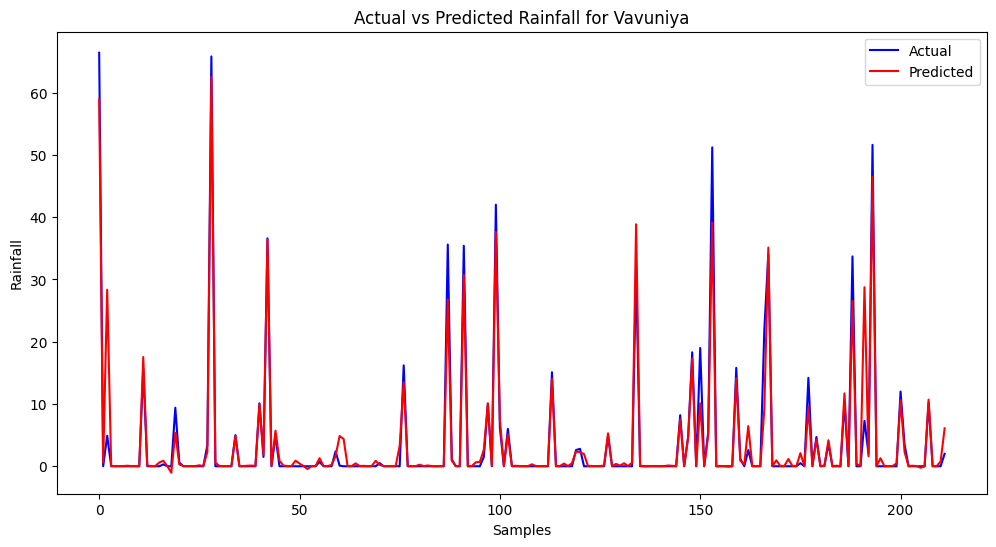

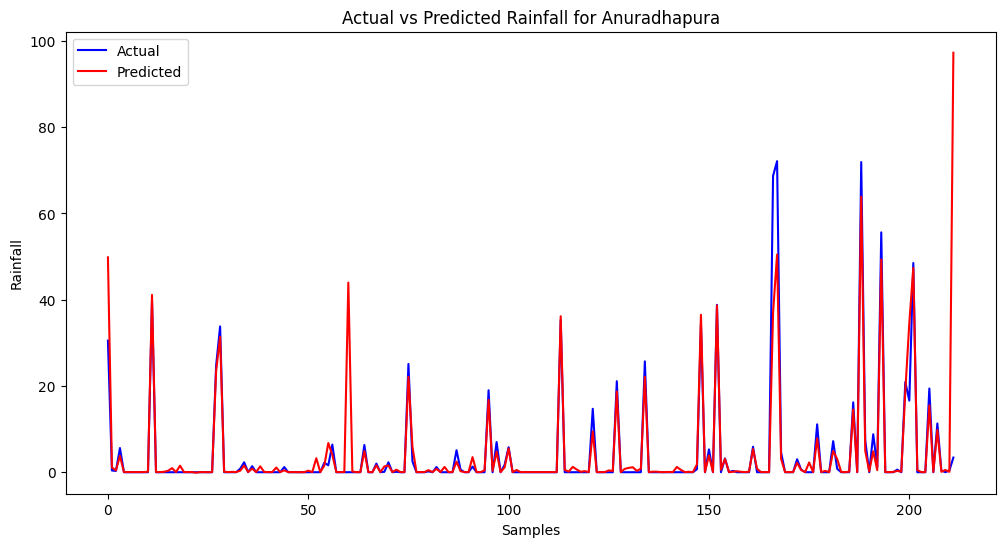

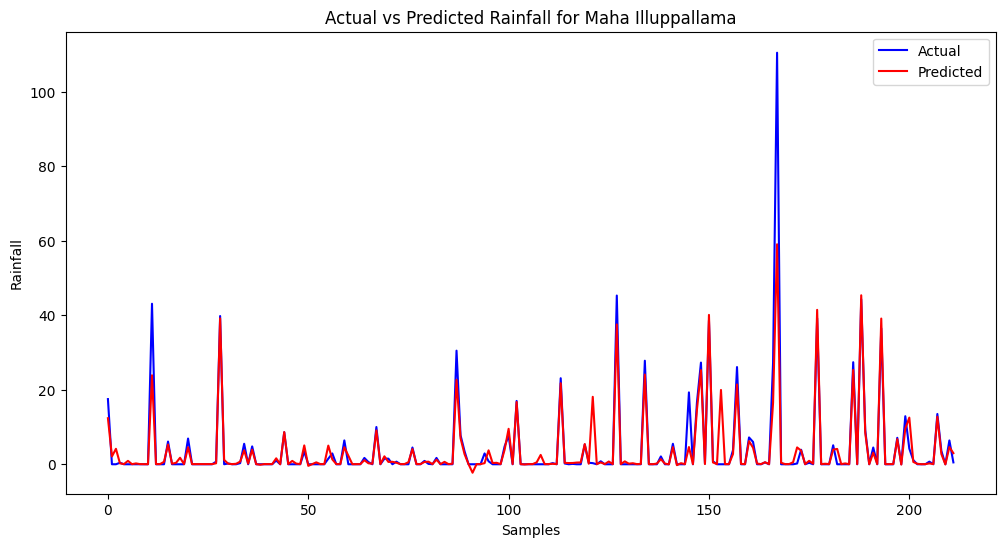

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import xgboost as xgb

# Load your dataset
df = pd.read_csv('transformed_rainfall_data.csv')

# Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

# Create additional features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfYear'] = df['Date'].dt.dayofyear

# Create lag features and rolling mean features for each station
stations = ['Vavuniya', 'Anuradhapura', 'Maha Illuppallama']
for station in stations:
    df[f'{station}_lag1'] = df[station].shift(1)
    df[f'{station}_lag2'] = df[station].shift(2)
    df[f'{station}_lag3'] = df[station].shift(3)
    df[f'{station}_rolling_mean3'] = df[station].rolling(window=3).mean()
    df[f'{station}_rolling_mean7'] = df[station].rolling(window=7).mean()

# Drop the rows with NaN values created by the shift operation
df.dropna(inplace=True)

# Prepare the dataset for each station
results = {}
predictions = {}

for station in stations:
    # Define features and target
    features = ['Year', 'Month', 'DayOfYear',
                f'{station}_lag1', f'{station}_lag2', f'{station}_lag3',
                f'{station}_rolling_mean3', f'{station}_rolling_mean7']
    X = df[features]
    y = df[station]

    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    X = imputer.fit_transform(X)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define the XGBoost model with Grid Search
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    xgbr = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    grid_search = GridSearchCV(estimator=xgbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    
    # Train the model
    grid_search.fit(X_train, y_train)
    
    # Predict and evaluate
    best_xgbr = grid_search.best_estimator_
    y_pred = best_xgbr.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[station] = {
        'MAE': mae,
        'MSE': mse,
        'R2': r2
    }
    
    predictions[station] = {
        'y_test': y_test,
        'y_pred': y_pred
    }
    
    print(f'Results for {station}:')
    print(f'  MAE: {mae}')
    print(f'  MSE: {mse}')
    print(f'  R2: {r2}')
    print()

# Display the results
for station, metrics in results.items():
    print(f'{station} - MAE: {metrics["MAE"]}, MSE: {metrics["MSE"]}, R2: {metrics["R2"]}')

# Plotting the results
for station in stations:
    plt.figure(figsize=(12, 6))
    plt.plot(predictions[station]['y_test'].values, label='Actual', color='blue')
    plt.plot(predictions[station]['y_pred'], label='Predicted', color='red')
    plt.title(f'Actual vs Predicted Rainfall for {station}')
    plt.xlabel('Samples')
    plt.ylabel('Rainfall')
    plt.legend()
    plt.show()
